
## Problem Statement
The objective of this project is to predict 3 months of item-level sales at different store locations.




Data fields
•	date - Date of the sale data. There are no holiday effects or store closures.
•	store - Store ID
•	item - Item ID
•	sales - Number of items sold at a particular store on a particular date.


# Import Libraries

In [ ]:
!pip install pyramid-arima


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#from jupyterthemes import jtplot
#jtplot.style(theme='chesterish')

from scipy.spatial.distance import euclidean #used for fdt
import fastdtw as fdt #fast dynamic time warping
from statsmodels.tsa.seasonal import seasonal_decompose #decompose seasonality
from statsmodels.tsa.stattools import adfuller #test if series is stationary (then can perform ARIMA)

from pyramid.arima import auto_arima #auto ARIMA model 
import xgboost as xgb #xgboost model
import tensorflow as tf #DNN estimator model

path = '../input/'

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/insaid2018/Term-3/master/Projects/Store_Item_demand_forecast.csv")


In [ ]:
df.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [ ]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
df.describe(include='all')

,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
unique,1826,NaN,NaN,NaN
top,2016-10-15,NaN,NaN,NaN
freq,500,NaN,NaN,NaN
mean,NaN,5.500000,25.500000,52.250287
std,NaN,2.872283,14.430878,28.801144
min,NaN,1.000000,1.000000,0.000000
25%,NaN,3.000000,13.000000,30.000000
50%,NaN,5.500000,25.500000,47.000000
75%,NaN,8.000000,38.000000,70.000000


In [ ]:
print("Store data available from \n", df.date.min(), " to " ,df.date.max(), "\n\n")

Store data available from 
 2013-01-01  to  2017-12-31 




# Observation: Data Description

10 stores
1-50 items across 10 stores
mean sales of 52.25 
Store data available from 2013-01-01 to 2017-12-31 

# Date format to be corrected to DateTime

In [ ]:
df['date'] = df['date'].astype('datetime64[ns]')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [ ]:
df.describe(include='all')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
unique,1826,NaN,NaN,NaN
top,2017-07-04 00:00:00,NaN,NaN,NaN
freq,500,NaN,NaN,NaN
first,2013-01-01 00:00:00,NaN,NaN,NaN
last,2017-12-31 00:00:00,NaN,NaN,NaN
mean,NaN,5.500000,25.500000,52.250287
std,NaN,2.872283,14.430878,28.801144
min,NaN,1.000000,1.000000,0.000000
25%,NaN,3.000000,13.000000,30.000000


In [ ]:
#extract the day, month & year
df['day'] = df.date.dt.day 
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year 
df.head()

,date,store,item,sales,day,month,year
0,2013-01-01,1,1,13,1,1,2013
1,2013-01-02,1,1,11,2,1,2013
2,2013-01-03,1,1,14,3,1,2013
3,2013-01-04,1,1,13,4,1,2013
4,2013-01-05,1,1,10,5,1,2013


# Store Trends
Here we're looking to see if there are any seasonality trends in the total store sales. We'll group by week so we can more clearly see trends in the plots

In [ ]:
stores = pd.DataFrame(df.groupby(['date','store']).sum()['sales']).unstack()
stores = stores.resample('7D',label='left').sum()
stores.sort_index(inplace = True)

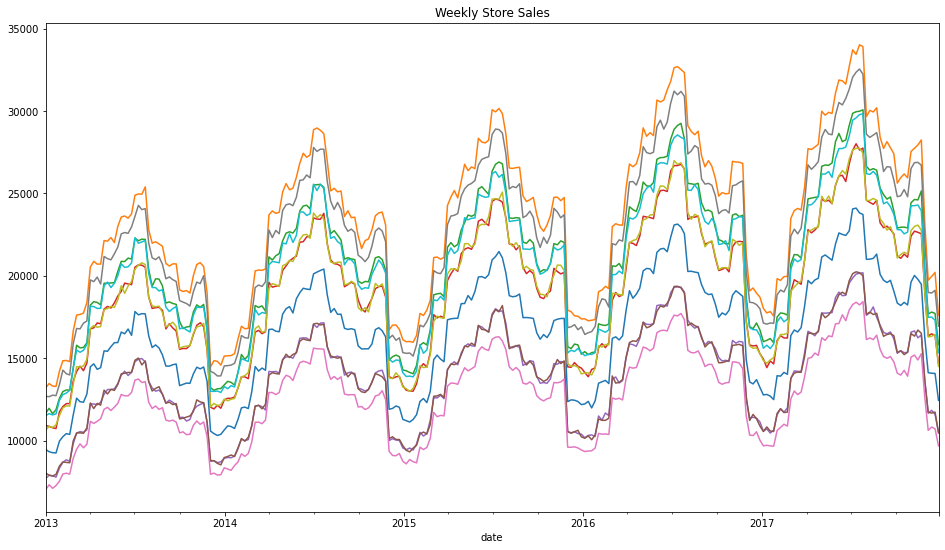

In [ ]:
stores.plot(figsize=(16,9), title='Weekly Store Sales', legend=None)
plt.show()

The above plot charts every store's sales by week. But how does the average trend? The 25% quartile?

Let's look:

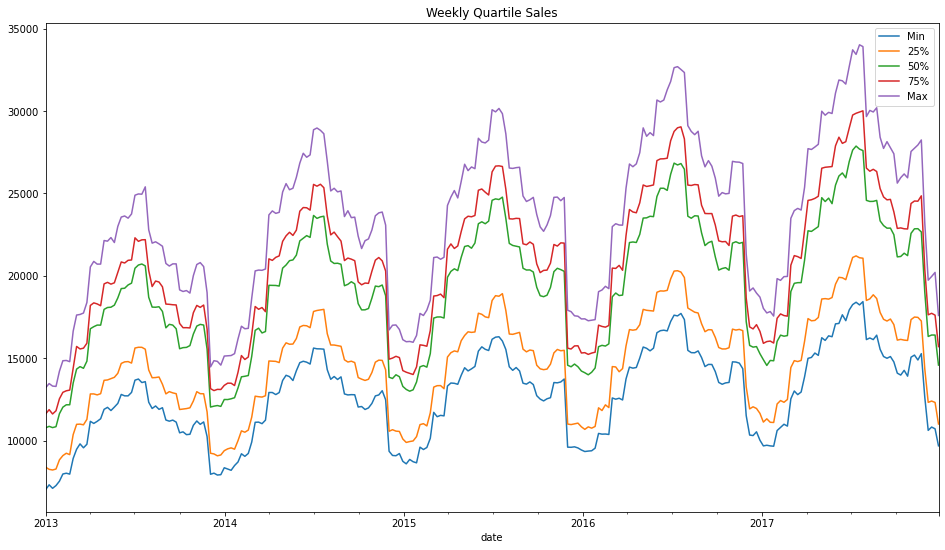

In [ ]:
store_qtr = pd.DataFrame(stores.quantile([0.0,0.25,0.5,0.75,1.0],axis=1)).transpose()
store_qtr.sort_index(inplace = True)
store_qtr.columns = ['Min','25%','50%','75%','Max']
store_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

We can see there's quite a gap between the 25% quartile and average. However, as the other chart shows as well, each store shares a general seasonality. They have highs and lows during the same periods of time.

Let's take a look at the seasonality aspect of the average. But before that, we're going to track the week-to-week difference.

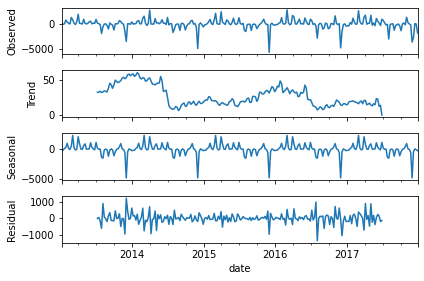

In [ ]:
seasonal = seasonal_decompose(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.suptitle = 'Additive Seasonal Decomposition of Average Store Week-to-Week Sales'
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [16,9]

Metrics and 2 Models
Error Metric
We'll be using the Symmetric Mean Absolute Percentage Error as our forecasting error metric. Defining a function saves us from writing the code multiple times.

In [ ]:
def SMAPE (forecast, actual):
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2
    
    print('SMAPE Error Score: ' + str(round(sum(diff/avg)/len(forecast) * 100, 2)) + ' %')

Stationarity Test (Dickey Fuller)
Time Series data should be stationary before applying an ARIMA model. Stationary means that the mean, standard deviation, and variance don't change over time. The function below tests whether or not a Time Series is stationary.

In [ ]:
def Fuller(TimeSeries):
    """Provides Fuller test results for TimeSeries"""
    stationary_test = adfuller(TimeSeries)
    print('ADF Statistic: %f' % stationary_test[0])
    print('p-value: %f' % stationary_test[1])
    print('Critical Values:')
    for key, value in stationary_test[4].items():
        print('\t%s: %.3f' % (key, value))

ARIMA Model
General ARIMA model that will be used.



In [ ]:
def ARIMA(TimeSeries, maxP, maxQ, maxD):
    #Returns ARIMA model (not fitted)
    stepwise_model = auto_arima(TimeSeries, start_p=1, start_q=1,
                           max_p=maxP, max_q=maxQ,
                           start_P=0, seasonal=True,
                           d=1, max_d=maxD, D=1, trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                           maxiter=500)
    print(stepwise_model.aic())
    return stepwise_model

In [ ]:
Fuller(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0])

ADF Statistic: -5.965889
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


Store Trends Conclusion
There is definitely seasonality in the store sales. Taking the week-to-week difference provides a dataset that is very likely to be stationary (< 1% chance that it's not). If we were to use this as a starting point for our model, we could cluster the stores to the nearest 25% quartile.

Item Sales Trends
Now we'll do the same analysis for the total item sales. And again, we're looking at weekly sales.

In [ ]:
items = pd.DataFrame(df.groupby(['date','item']).sum()['sales']).unstack()
items = items.resample('7D',label='left').sum()
items.sort_index(inplace = True)

items.tail(13)

sales                          ...                              
item          1     2     3     4     5   ...    46    47    48    49    50
date                                      ...                              
2017-10-03  1769  4471  2740  1677  1372  ...  4620  1696  3973  2285  5054
2017-10-10  1758  4454  2858  1757  1392  ...  4529  1644  3949  2208  4967
2017-10-17  1732  4481  2856  1700  1396  ...  4560  1700  3949  2260  5070
2017-10-24  1662  4422  2767  1724  1456  ...  4494  1739  4021  2202  5074
2017-10-31  1774  4798  3087  1680  1476  ...  4889  1798  4257  2468  5323
2017-11-07  1735  4887  3143  1879  1540  ...  4947  1820  4291  2417  5542
2017-11-14  1824  4812  3094  1816  1479  ...  4884  1755  4318  2475  5349
2017-11-21  1818  4840  3076  1876  1576  ...  4915  1860  4329  2364  5517
2017-11-28  1490  4042  2527  1509  1301  ...  4028  1591  3580  1991  4503
2017-12-05  1311  3551  2182  1296  1179  ...  3510  1283  3101  1669  3829
2017-12-12  1308  3498  2251  1277  1125  ...  3483  1279  3051  1701  3856
2017-12-19  1262  3450  2181  1306  1085  ...  3524  1361  3177  1689  3900
2017-12-26  1167  3180  1956  1150  1000  ...  3182  1166  2655  1546  3411

[13 rows x 50 columns]

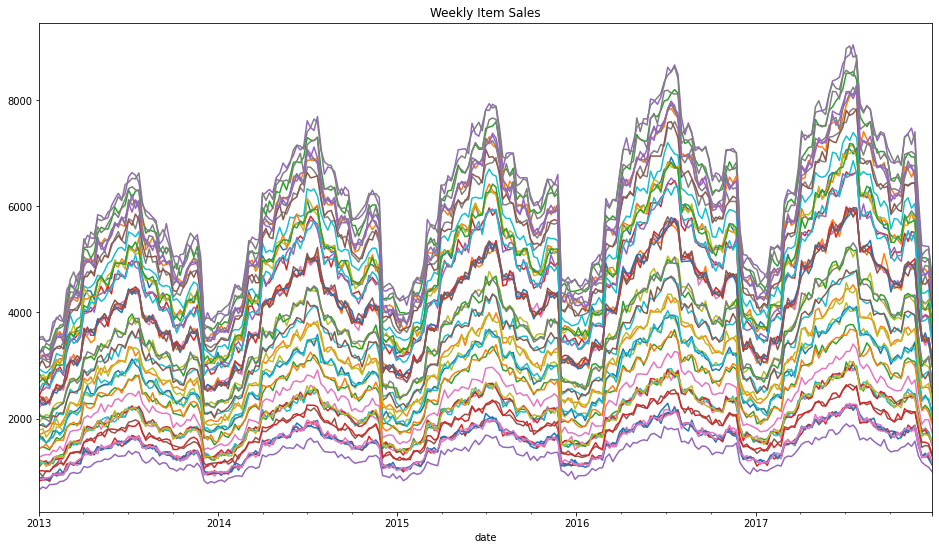

In [ ]:
items.plot(figsize=(16,9), title='Weekly Item Sales', legend=None)
plt.show()

Since there are more items than there were stores, we can look at more quartiles. Let's see how every 10% quartile trends.

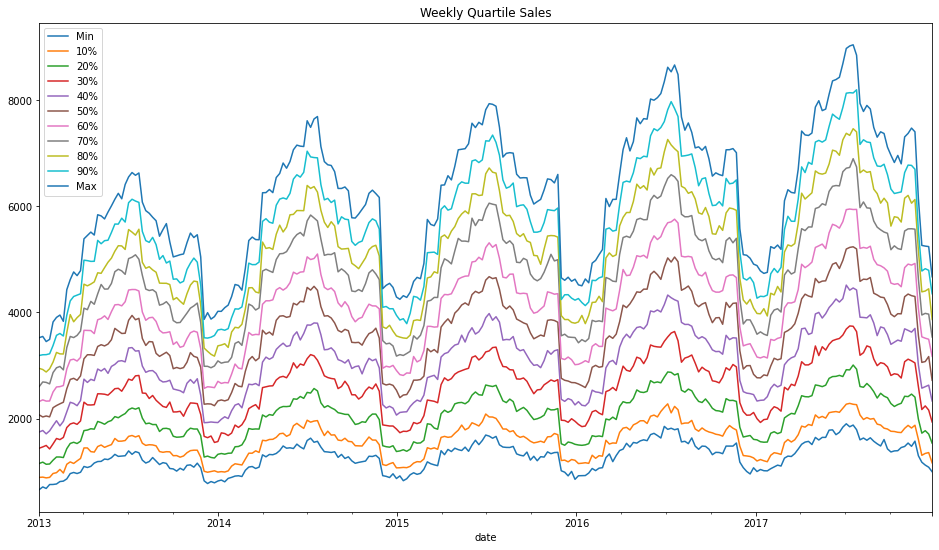

In [ ]:
item_WK_qtr = pd.DataFrame(items.quantile([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],axis=1)).transpose()
item_WK_qtr.sort_index(inplace = True)
item_WK_qtr.columns = ['Min','10%','20%','30%','40%','50%','60%','70%','80%','90%','Max']
item_WK_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

Like we saw in the store sales plots, there is seasonality in item sales. Let's break out the seasonal component for the average like we had before:

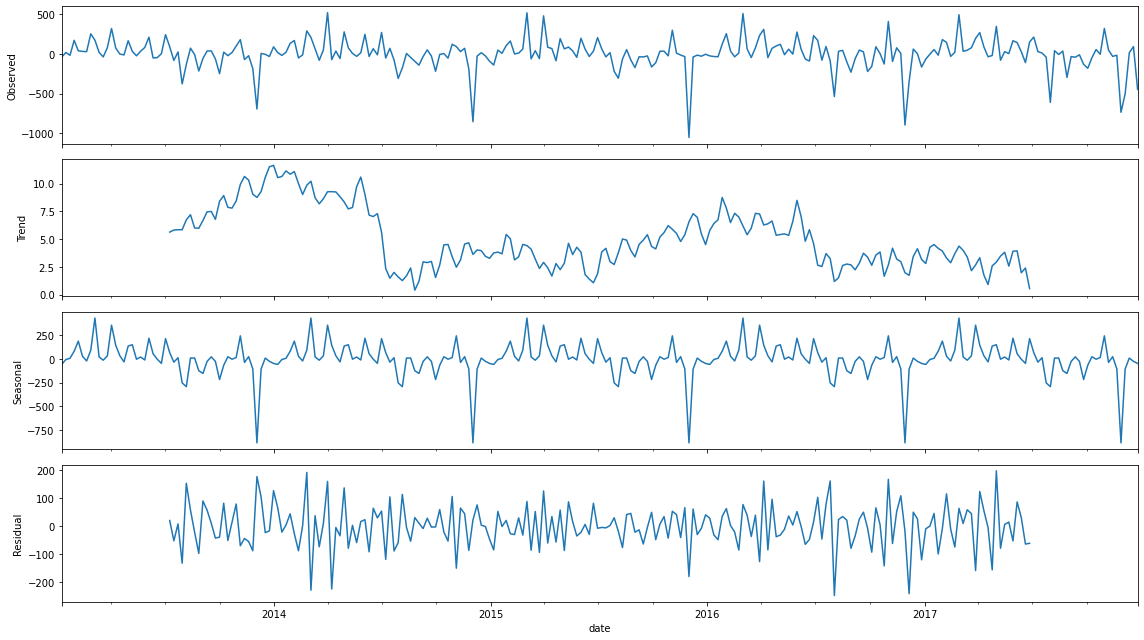

In [ ]:
seasonal = seasonal_decompose(pd.DataFrame(item_WK_qtr['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.title = 'Additive Seasonal Decomposition of Average Item Week-to-Week Sales'
plt.show()

In [ ]:
Fuller(pd.DataFrame(item_WK_qtr['50%']).diff(1).iloc[1:,0])

ADF Statistic: -13.061788
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


Item Trend Conclusion
Item sales are also seasonal. No surprise there. Week-to-week differencing provides a dataset that is very likely to be stationary (< 1% chance that it's not). If we were to use this as a basis for our model, we could cluster the items to the nearest 10% quartile

# **Store & Item Variability**
We've seen how stores and items trend by themselves, but do some stores sell more of one item? In other words: do the stores have the same sales mix? Are the items sold evenly (percentage-wise) across all stores?

Below is a plot for the % distribution of each item's sales across the stores (each row adds to 100%). As we can see, it's very uniform. The takeaway here is that the items are sold evenly across the stores.

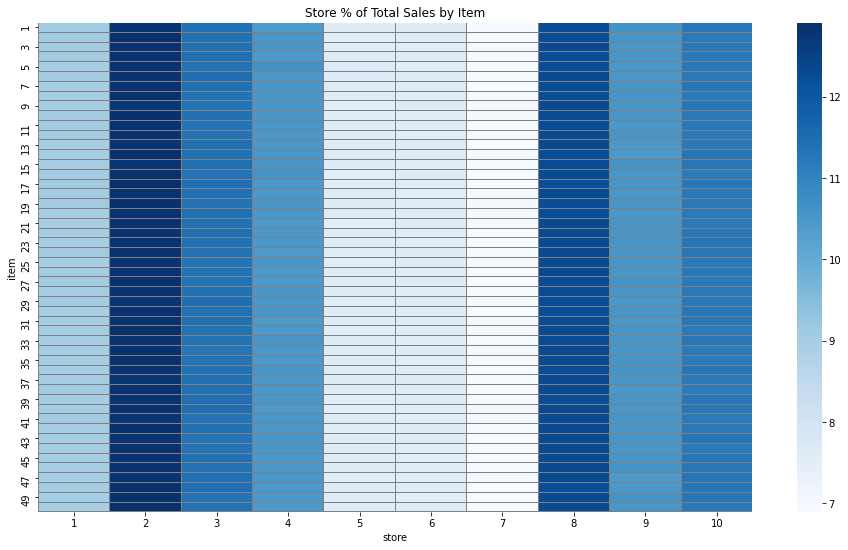

In [ ]:
store_item = df.groupby(by=['item','store']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(store_item, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Store % of Total Sales by Item')
plt.show()


In [ ]:
axa = df.groupby(by=['item','store']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()

In [ ]:
axa

store,1,2,3,4,5,6,7,8,9,10
item,,,,,,,,,,
1,9.085564,12.816904,11.405039,10.435394,7.615152,7.605435,6.896388,12.275527,10.611534,11.253064
2,9.073791,12.858324,11.405115,10.536256,7.595244,7.603005,6.951524,12.233490,10.549439,11.193814
3,9.062798,12.824640,11.399713,10.520157,7.596620,7.589895,6.967704,12.301689,10.516570,11.220215
4,9.066774,12.828092,11.411098,10.488994,7.622161,7.611960,6.977734,12.243629,10.517856,11.231703
5,9.049011,12.822540,11.361155,10.635385,7.672941,7.567640,6.936133,12.216389,10.497569,11.241237
6,9.069617,12.810300,11.453447,10.472900,7.617378,7.606987,6.957439,12.299760,10.497144,11.215027
7,9.018065,12.823723,11.386753,10.528670,7.608884,7.619737,6.955239,12.255129,10.560575,11.243225
8,9.028203,12.877231,11.373289,10.502894,7.610874,7.587459,6.981670,12.275640,10.563672,11.199068
9,9.049435,12.741440,11.381009,10.516433,7.557394,7.678561,6.986196,12.296844,10.528475,11.264212


In [ ]:
store_item.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 1 to 50
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       50 non-null     float64
 1   2       50 non-null     float64
 2   3       50 non-null     float64
 3   4       50 non-null     float64
 4   5       50 non-null     float64
 5   6       50 non-null     float64
 6   7       50 non-null     float64
 7   8       50 non-null     float64
 8   9       50 non-null     float64
 9   10      50 non-null     float64
dtypes: float64(10)
memory usage: 4.3 KB


Now to confirm, let's look at the % distribution of each store's sales across the different items (each row adds to 100%).

We can see that each store overall sold roughly the same percentage of each item.

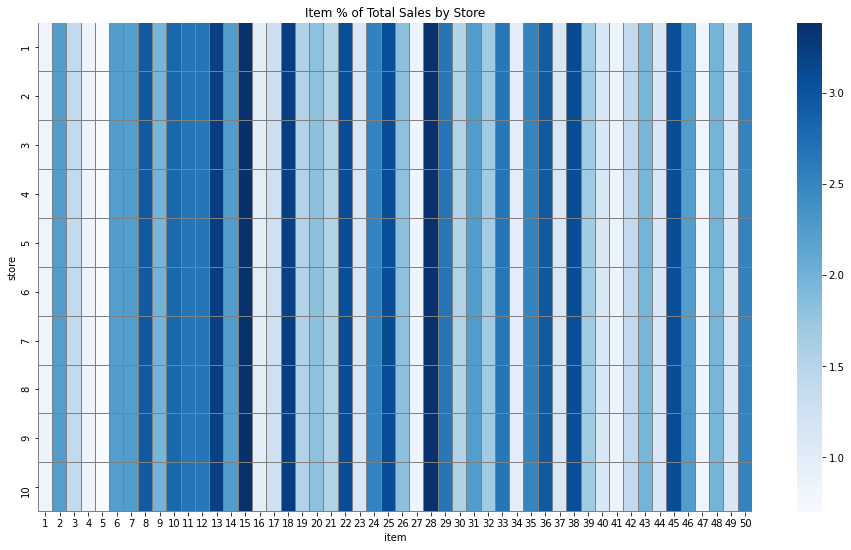

In [ ]:
item_store = df.groupby(by=['store','item']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(item_store , cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Item % of Total Sales by Store')
plt.show()

# Store vs Item Conclusion
Items have roughly same percentage sales across all stores. We could use this in our model.

Day of Week Variability
How do sales vary by day of week? Is there seasonality as well? Do stores share same trends?

In [ ]:
df.head()

,date,store,item,sales,day,month,year,weekday,dayname
0,2013-01-01,1,1,13,1,1,2013,1,Tuesday
1,2013-01-02,1,1,11,2,1,2013,2,Wednesday
2,2013-01-03,1,1,14,3,1,2013,3,Thursday
3,2013-01-04,1,1,13,4,1,2013,4,Friday
4,2013-01-05,1,1,10,5,1,2013,5,Saturday


In [ ]:
import datetime

df['weekday'] = df.date.dt.dayofweek
df['dayname'] = df.date.dt.day_name()
df.head()

,date,store,item,sales,day,month,year,weekday,dayname
0,2013-01-01,1,1,13,1,1,2013,1,Tuesday
1,2013-01-02,1,1,11,2,1,2013,2,Wednesday
2,2013-01-03,1,1,14,3,1,2013,3,Thursday
3,2013-01-04,1,1,13,4,1,2013,4,Friday
4,2013-01-05,1,1,10,5,1,2013,5,Saturday


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   date     913000 non-null  datetime64[ns]
 1   store    913000 non-null  int64         
 2   item     913000 non-null  int64         
 3   sales    913000 non-null  int64         
 4   day      913000 non-null  int64         
 5   month    913000 non-null  int64         
 6   year     913000 non-null  int64         
 7   weekday  913000 non-null  int64         
 8   dayname  913000 non-null  object        
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 62.7+ MB


In [ ]:
df.head()

,date,store,item,sales,day,month,year,weekday,dayname
0,2013-01-01,1,1,13,1,1,2013,1,Tuesday
1,2013-01-02,1,1,11,2,1,2013,2,Wednesday
2,2013-01-03,1,1,14,3,1,2013,3,Thursday
3,2013-01-04,1,1,13,4,1,2013,4,Friday
4,2013-01-05,1,1,10,5,1,2013,5,Saturday


In [ ]:
df

,date,store,item,sales,day,month,year,weekday,dayname
0,2013-01-01,1,1,13,1,1,2013,1,Tuesday
1,2013-01-02,1,1,11,2,1,2013,2,Wednesday
2,2013-01-03,1,1,14,3,1,2013,3,Thursday
3,2013-01-04,1,1,13,4,1,2013,4,Friday
4,2013-01-05,1,1,10,5,1,2013,5,Saturday
...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,27,12,2017,2,Wednesday
912996,2017-12-28,10,50,59,28,12,2017,3,Thursday
912997,2017-12-29,10,50,74,29,12,2017,4,Friday
912998,2017-12-30,10,50,62,30,12,2017,5,Saturday


In [ ]:
df_1 = df.copy()

In [ ]:
df_sales = pd.DataFrame(df_1.groupby(['store','weekday'])['sales'].sum().unstack().T)
df_sales.reset_index(inplace=True)

df_sales.head(7)

store,weekday,1,2,3,4,5,6,7,8,9,10
0,0,487131,690800,613606,565540,410997,409779,375245,661126,566198,605431
1,1,568457,806748,717008,661036,479176,479196,438431,773145,663233,707051
2,2,572094,809388,720062,662768,480366,481078,440086,773978,663804,708466
3,3,609842,866521,768908,709383,514382,512470,469977,828498,711445,758454
4,4,650430,924172,819427,756896,546863,547159,499333,883783,759779,810179
5,5,693334,981624,872627,804665,582482,582553,532618,939144,807363,859072
6,6,734315,1040875,923506,852351,616750,615435,564319,996495,854154,911505


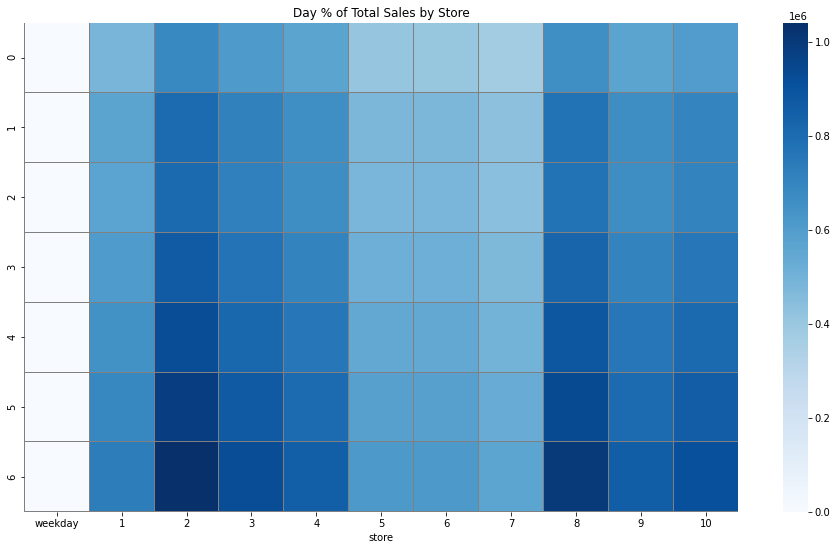

In [ ]:
sns.heatmap(df_sales, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Day % of Total Sales by Store')
plt.show()

In [ ]:
dow_store = df_1.groupby(['store','dayname'])['sales'].sum().groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
                                                'Tuesday',
                                                'Wednesday',
                                                'Thursday',
                                                'Friday',
                                                'Saturday',
                                                'Sunday']]

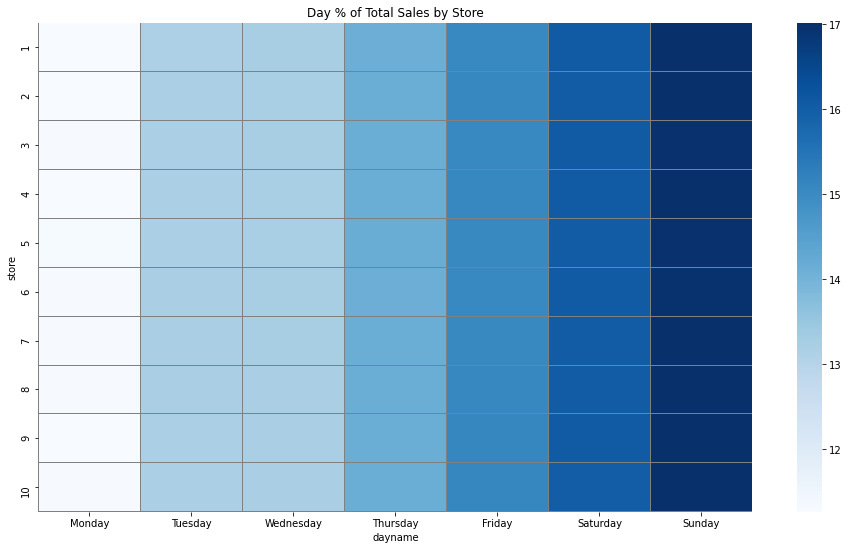

In [ ]:
#dow_store = df.groupby(['store','Day']).sum()['sales'].groupby(level=0).apply(
#    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
#                                                'Tuesday',
#                                                'Wednesday',
#                                                'Thursday',
#                                                'Friday',
#                                                'Saturday',
#                                                'Sunday']]
sns.heatmap(dow_store, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Day % of Total Sales by Store')
plt.show()

The plot above shows the % mix of store sales by day. We can see that the stores are very similar in what days are popular.

Let's do the same for the items.

In [ ]:
dow_item = df_1.groupby(['item','dayname'])['sales'].sum().groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
                                                'Tuesday',
                                                'Wednesday',
                                                'Thursday',
                                                'Friday',
                                                'Saturday',
                                                'Sunday']]

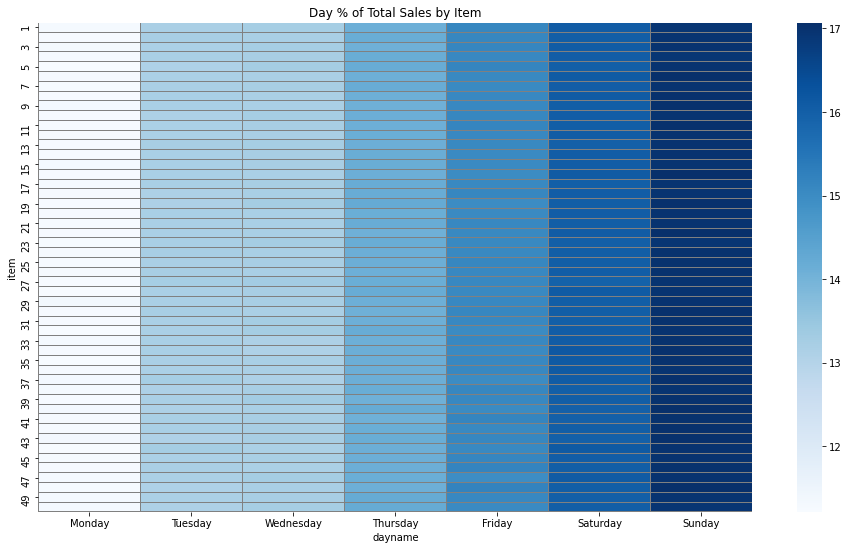

In [ ]:
#dow_item = df.groupby(['item','Day']).sum()['sales'].groupby(level=0).apply(
#   lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
#                                              'Tuesday',
#                                                'Wednesday',
#                                                'Thursday',
#                                                'Friday',
#                                                'Saturday',
#                                                'Sunday']]
sns.heatmap(dow_item, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Day % of Total Sales by Item')
plt.show()

This plot tells us that each item's sales are nearly identical in terms of which days are more popular.

Now let's see if each day generally trends the same as the total week.

In [ ]:
dow = pd.DataFrame(df.groupby(['date','dayname']).sum()['sales']).unstack()['sales'].loc[:,
                                                                                ['Monday',
                                                                               'Tuesday',
                                                                               'Wednesday',
                                                                               'Thursday',
                                                                               'Friday',
                                                                               'Saturday',
                                                                               'Sunday']]
dow = dow.resample('7D',label='left').sum()
dow.sort_index(inplace = True)

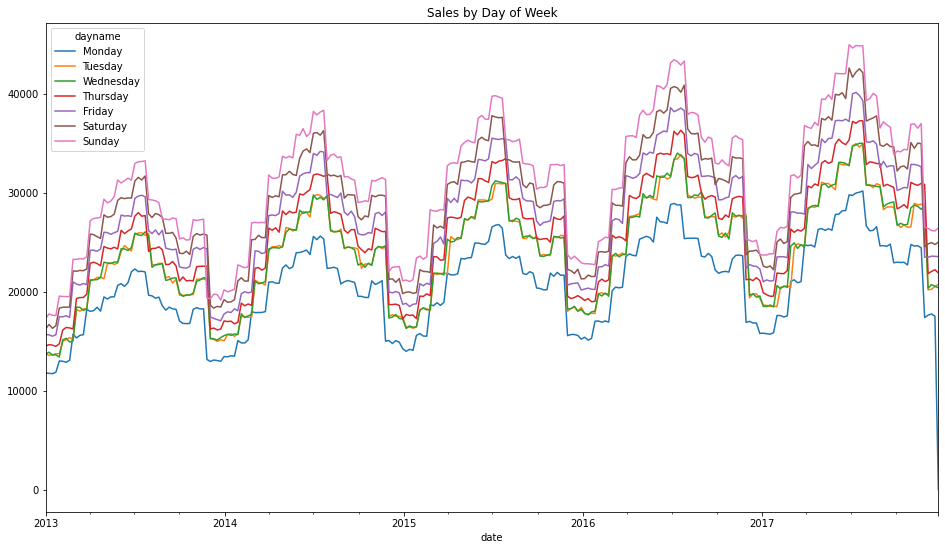

In [ ]:
dow.plot(figsize=(16,9), title='Sales by Day of Week')
plt.show()

Day of Week Conclusion
Day of week does impact sales, however all stores & items have similar distributions. Day of week trends follow general weekly trend.

# Findings and Steps Forward

Items and stores weekly sales have seasonality and can be munged into a stationary dataset. They also have similar day of week variability, and items have roughly same distributions in stores.

# Modeling Process

Split the data into train and test data (3 months of test). Will compare  model outlined below. The goal is to find the model's accuracy

Model 

Forecast weekly item sales with ARIMA
Percentages will be used to find item sales by store by day

Item daily sales with added features:
Day of year (in mod 364)
Day of Quarter (in mod 91)
Quarter (in mod 4)
Day of week (binary columns)
Month
Prior year sales
Average sales by item by store by day of year
Average sales by item by store by day of week by quarter
Whether or not a weekend (Fri-Sun)
Dynamic Time Warping (DTW) on item weekly sales to cluster to nearest 10% quartile
Forecast with xgboost

# ARIMA Model

Model - Clustered Weekly Data

NOTE: Most of the ARIMA model code is commented due to Kaggle only allowing one custom library. Error results are reported at the end of each model.

Will be using the 10% quartile weekly item sales that was created during the exploratory analysis. Since the competition is predicting the next 3 months of sales, we will use 3 months (13 weeks) of test data.

We will build an ARIMA model for each quartile then use clustering and percentages to arrive at daily items sales by store.

In [ ]:
item_WK_qtr

,Min,10%,20%,30%,40%,50%,60%,70%,80%,90%,Max
date,,,,,,,,,,,
2013-01-01,664.0,893.1,1156.8,1443.7,1749.2,2069.0,2324.0,2605.9,2946.0,3190.0,3526.0
2013-01-08,714.0,898.3,1180.4,1467.4,1776.6,2031.5,2353.6,2691.4,2925.4,3203.4,3548.0
2013-01-15,685.0,884.1,1140.6,1495.1,1713.6,2050.0,2330.2,2682.8,2878.8,3205.2,3452.0
2013-01-22,759.0,893.5,1145.8,1429.2,1770.0,2033.5,2332.6,2654.7,2938.6,3221.9,3493.0
2013-01-29,760.0,966.8,1217.6,1524.7,1867.6,2206.5,2502.8,2868.1,3065.4,3377.8,3821.0
...,...,...,...,...,...,...,...,...,...,...,...
2017-11-28,1301.0,1608.1,1990.6,2602.6,3012.4,3564.0,4073.2,4631.0,5169.4,5528.0,6145.0
2017-12-05,1179.0,1309.5,1726.6,2171.8,2573.8,3059.5,3540.8,3952.4,4388.4,4780.2,5263.0
2017-12-12,1125.0,1344.9,1773.0,2239.6,2603.2,3075.5,3515.2,3983.1,4403.6,4824.9,5250.0


In [ ]:
train = item_WK_qtr[:-13]
#test = df.loc[df.index >= pd.to_datetime('October 3, 2017')] # last 13 weeks of data

In [ ]:
test = item_WK_qtr.loc[item_WK_qtr.index >= pd.to_datetime('October 3, 2017')] # last 13 weeks of data

In [ ]:
train

,Min,10%,20%,30%,40%,50%,60%,70%,80%,90%,Max
date,,,,,,,,,,,
2013-01-01,664.0,893.1,1156.8,1443.7,1749.2,2069.0,2324.0,2605.9,2946.0,3190.0,3526.0
2013-01-08,714.0,898.3,1180.4,1467.4,1776.6,2031.5,2353.6,2691.4,2925.4,3203.4,3548.0
2013-01-15,685.0,884.1,1140.6,1495.1,1713.6,2050.0,2330.2,2682.8,2878.8,3205.2,3452.0
2013-01-22,759.0,893.5,1145.8,1429.2,1770.0,2033.5,2332.6,2654.7,2938.6,3221.9,3493.0
2013-01-29,760.0,966.8,1217.6,1524.7,1867.6,2206.5,2502.8,2868.1,3065.4,3377.8,3821.0
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-29,1574.0,2002.3,2509.2,3123.3,3802.2,4362.5,4998.6,5721.9,6322.6,6911.9,7485.0
2017-09-05,1526.0,1896.8,2387.8,2998.0,3563.6,4330.0,4900.4,5607.1,6239.2,6759.0,7302.0
2017-09-12,1485.0,1880.0,2477.6,3053.9,3727.2,4289.0,4879.8,5556.7,6059.4,6750.4,7403.0


In [ ]:
test
 

,Min,10%,20%,30%,40%,50%,60%,70%,80%,90%,Max
date,,,,,,,,,,,
2017-10-03,1372.0,1761.7,2283.8,2813.5,3399.8,3968.0,4553.4,5182.0,5626.8,6325.1,6963.0
2017-10-10,1392.0,1757.9,2229.0,2845.1,3440.6,3920.5,4530.2,5255.0,5803.2,6240.9,6825.0
2017-10-17,1396.0,1742.8,2264.8,2832.6,3479.8,3977.0,4543.2,5203.2,5789.6,6255.4,6958.0
2017-10-24,1456.0,1737.5,2289.6,2765.2,3458.0,3974.0,4484.4,5186.1,5703.0,6270.8,6799.0
2017-10-31,1476.0,1816.8,2421.2,3072.3,3692.0,4297.0,4844.6,5535.0,6153.0,6635.5,7307.0
2017-11-07,1540.0,1873.1,2415.2,3120.2,3662.6,4346.5,4911.0,5574.4,6205.2,6776.2,7373.0
2017-11-14,1479.0,1823.2,2461.6,3088.6,3630.2,4316.5,4892.4,5576.8,6058.2,6770.4,7473.0
2017-11-21,1576.0,1875.6,2405.6,3049.3,3699.4,4301.0,4923.4,5568.9,6127.8,6698.3,7403.0
2017-11-28,1301.0,1608.1,1990.6,2602.6,3012.4,3564.0,4073.2,4631.0,5169.4,5528.0,6145.0


In [ ]:
fitted_items_WK = []
qtr_list = [0] *11

for column in items:
    for c in range(11):
        qtr_list[c] = [fdt.fastdtw(items[column],item_WK_qtr.iloc[:,c], dist= euclidean)[0], c]
    qtr_list.sort()
    fitted_items_WK.append([column[1], qtr_list[0][1], qtr_list[0][0]])

Fitting Models and Forecasting

In [ ]:
ARIMA_predictions = pd.DataFrame()

for column in item_WK_qtr:
    model = ARIMA(item_WK_qtr[column], 52, 52, 52)
    model.fit(train[column])
    ARIMA_predictions[column] = model.predict(n_periods=13)

3049.6417768558194
3086.614564046044
3197.7717643577444
3332.275339581939
3405.889532688381
3475.136067209135
3538.465431648969
3604.1951850408213
3658.8425632919193
3700.589050589141
3749.32942135407


In [ ]:
item_WK_predictions = pd.DataFrame()

for i in range(50):
    item_WK_predictions[fitted_items_WK[i][0]] = ARIMA_predictions.iloc[:,fitted_items_WK[i][1]]

item_WK_predictions.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,1806.647165,4775.086934,2973.300279,1806.647165,1433.101215,4775.086934,4775.086934,6063.280038,4131.408858,6063.280038,5497.297984,5497.297984,6575.725696,4775.086934,7084.982562,1806.647165,2973.300279,6575.725696,2973.300279,3580.759296,2973.300279,6575.725696,2394.891200,5497.297984,6575.725696,3580.759296,1806.647165,7084.982562,5497.297984,2973.300279,4775.086934,3580.759296,5497.297984,1806.647165,5497.297984,6063.280038,2394.891200,6575.725696,3580.759296,2394.891200,1806.647165,2973.300279,4131.408858,2394.891200,6575.725696,4775.086934,1806.647165,4131.408858,2394.891200,5497.297984
1,1810.191385,4783.570536,2979.141170,1810.191385,1436.202429,4783.570536,4783.570536,6073.639825,4139.012251,6073.639825,5507.238798,5507.238798,6588.217025,4783.570536,7097.648295,1810.191385,2979.141170,6588.217025,2979.141170,3591.539334,2979.141170,6588.217025,2399.891612,5507.238798,6588.217025,3591.539334,1810.191385,7097.648295,5507.238798,2979.141170,4783.570536,3591.539334,5507.238798,1810.191385,5507.238798,6073.639825,2399.891612,6588.217025,3591.539334,2399.891612,1810.191385,2979.141170,4139.012251,2399.891612,6588.217025,4783.570536,1810.191385,4139.012251,2399.891612,5507.238798
2,1813.735605,4792.054137,2984.982061,1813.735605,1439.303644,4792.054137,4792.054137,6085.851944,4146.615644,6085.851944,5517.179611,5517.179611,6600.708354,4792.054137,7110.314029,1813.735605,2984.982061,6600.708354,2984.982061,3597.795410,2984.982061,6600.708354,2404.892024,5517.179611,6600.708354,3597.795410,1813.735605,7110.314029,5517.179611,2984.982061,4792.054137,3597.795410,5517.179611,1813.735605,5517.179611,6085.851944,2404.892024,6600.708354,3597.795410,2404.892024,1813.735605,2984.982061,4146.615644,2404.892024,6600.708354,4792.054137,1813.735605,4146.615644,2404.892024,5517.179611
3,1817.279824,4800.537739,2990.822952,1817.279824,1442.404858,4800.537739,4800.537739,6098.338999,4154.219036,6098.338999,5527.120425,5527.120425,6613.199683,4800.537739,7122.979763,1817.279824,2990.822952,6613.199683,2990.822952,3605.599525,2990.822952,6613.199683,2409.892436,5527.120425,6613.199683,3605.599525,1817.279824,7122.979763,5527.120425,2990.822952,4800.537739,3605.599525,5527.120425,1817.279824,5527.120425,6098.338999,2409.892436,6613.199683,3605.599525,2409.892436,1817.279824,2990.822952,4154.219036,2409.892436,6613.199683,4800.537739,1817.279824,4154.219036,2409.892436,5527.120425
4,1820.824044,4809.021341,2996.663842,1820.824044,1445.506073,4809.021341,4809.021341,6110.866862,4161.822429,6110.866862,5537.061238,5537.061238,6625.691012,4809.021341,7135.645496,1820.824044,2996.663842,6625.691012,2996.663842,3612.873922,2996.663842,6625.691012,2414.892848,5537.061238,6625.691012,3612.873922,1820.824044,7135.645496,5537.061238,2996.663842,4809.021341,3612.873922,5537.061238,1820.824044,5537.061238,6110.866862,2414.892848,6625.691012,3612.873922,2414.892848,1820.824044,2996.663842,4161.822429,2414.892848,6625.691012,4809.021341,1820.824044,4161.822429,2414.892848,5537.061238


Convert Item Weekly Predictions to Daily Predictions
Use day of week percentages from before to calculate daily item sales

In [ ]:
item_Day_pred = []

for column in item_WK_predictions:
    for i, row in item_WK_predictions.iterrows():
        for col in range(7):
            item_Day_pred.append([i, dow_item.columns[col], column, dow_item.iloc[int(column)-1,col]
                                 * item_WK_predictions[column][i]/100])
            
item_Day_fcst = pd.DataFrame(item_Day_pred, columns=['Week #','Day','item','Prediction'])

item_Day_fcst.head()

,Week #,Day,item,Prediction
0,0,Monday,1,204.356413
1,0,Tuesday,1,238.240275
2,0,Wednesday,1,239.820141
3,0,Thursday,1,254.777112
4,0,Friday,1,273.082859


Split Predictions by Store
Reshape the store_item DataFrame and use percentages to calculate daily item sales by store.

In [ ]:
store_item = pd.DataFrame(store_item.stack()).reset_index()
store_item.columns = ['item','store','pct']

item_Day_fcst = item_Day_fcst.merge(store_item, on= 'item')

item_Day_fcst['sales'] = item_Day_fcst['Prediction'] * item_Day_fcst['pct']/100

In [ ]:
store_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   item    500 non-null    int64  
 1   store   500 non-null    int64  
 2   pct     500 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 11.8 KB


In [ ]:
item_Day_fcst = item_Day_fcst.loc[:,['Week #','Day','store','item','sales']]

item_Day_fcst.head()

,Week #,Day,store,item,sales
0,0,Monday,1,1,18.566933
1,0,Monday,2,1,26.192164
2,0,Monday,3,1,23.306928
3,0,Monday,4,1,21.325396
4,0,Monday,5,1,15.562051


Convert Week Number and Day of Week into Datetime
Based on where the data was split for testing, the weeks start on Tuesdays so there's no offset then. This adds an additional day of data that we'll need to cutoff.

This is needed so we can remove the additional day in a readable way.

In [ ]:
def str_to_date(row):
    #Takes day of week string and week offset to calculate date
    switcher = {
        'Tuesday': 0, #data starts on a Tuesday, so 0 offset
        'Wednesday': 1,
        'Thursday': 2,
        'Friday': 3,
        'Saturday': 4,
        'Sunday': 5,
        'Monday': 6
    }
    weeks = pd.to_timedelta(7* row['Week #'], unit='D')
    days = pd.to_timedelta(switcher.get(row['Day']), unit='D')
    
    return pd.to_datetime('October 3, 2017') + weeks + days


item_Day_fcst['date'] = item_Day_fcst.apply(lambda row: str_to_date(row), axis=1)
item_Day_fcst.index = item_Day_fcst['date']

In [ ]:
item_Day_fcst.head()

,Week #,Day,store,item,sales,date
date,,,,,,
2017-10-09,0,Monday,1,1,18.566933,2017-10-09
2017-10-09,0,Monday,2,1,26.192164,2017-10-09
2017-10-09,0,Monday,3,1,23.306928,2017-10-09
2017-10-09,0,Monday,4,1,21.325396,2017-10-09
2017-10-09,0,Monday,5,1,15.562051,2017-10-09


In [ ]:
item_Day_fcst.sort_values(['item','store'], inplace=True)  #,'Date'
item_Day_fcst['sales']= round(item_Day_fcst['sales'], 0)

item_Day_fcst = item_Day_fcst[['store','item','sales']].loc[item_Day_fcst.index < pd.to_datetime('January 1, 2018')]

In [ ]:
item_Day_fcst.shape

(45000, 3)

In [ ]:
item_Day_fcst.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45000 entries, 2017-10-09 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   store   45000 non-null  int64  
 1   item    45000 non-null  int64  
 2   sales   45000 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


In [ ]:
item_Day_fcst

,store,item,sales
date,,,
2017-10-09,1,1,19.0
2017-10-03,1,1,22.0
2017-10-04,1,1,22.0
2017-10-05,1,1,23.0
2017-10-06,1,1,25.0
...,...,...,...
2017-12-27,10,50,84.0
2017-12-28,10,50,90.0
2017-12-29,10,50,95.0


In [ ]:
item_Day_fcst['sales']

date
2017-10-09     19.0
2017-10-03     22.0
2017-10-04     22.0
2017-10-05     23.0
2017-10-06     25.0
              ...  
2017-12-27     84.0
2017-12-28     90.0
2017-12-29     95.0
2017-12-30    101.0
2017-12-31    107.0
Name: sales, Length: 45000, dtype: float64

In [ ]:
actual_items = df[['date','store','item','sales']]

In [ ]:
actual_items.set_index('date', inplace=True)
actual_items.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [ ]:

actual_items.shape

(913000, 3)

In [ ]:
actual_items['sales']

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
              ..
2017-12-27    63
2017-12-28    59
2017-12-29    74
2017-12-30    62
2017-12-31    82
Name: sales, Length: 913000, dtype: int64

In [ ]:
forecasted_items = pd.DataFrame(item_Day_fcst['sales'])
forecasted_items.reset_index(inplace=True)
forecasted_items.sort_values(by='date', ascending=True, inplace=True)
forecasted_items

,date,sales
36451,2017-10-03,18.0
28351,2017-10-03,36.0
901,2017-10-03,57.0
43201,2017-10-03,28.0
39061,2017-10-03,24.0
...,...,...
30149,2017-12-31,24.0
30239,2017-12-31,24.0
30329,2017-12-31,22.0
30509,2017-12-31,33.0


In [ ]:
test_items = pd.DataFrame(actual_items['sales'].loc[actual_items['sales'].index >= pd.to_datetime('October 3, 2017')])
test_items.reset_index(inplace=True)
test_items

,date,sales
0,2017-10-03,18
1,2017-10-04,15
2,2017-10-05,20
3,2017-10-06,19
4,2017-10-07,22
...,...,...
44995,2017-12-27,63
44996,2017-12-28,59
44997,2017-12-29,74
44998,2017-12-30,62


In [ ]:
forecasted_items['sales']

36451     18.0
28351     36.0
901       57.0
43201     28.0
39061     24.0
         ...  
30149     24.0
30239     24.0
30329     22.0
30509     33.0
44999    107.0
Name: sales, Length: 45000, dtype: float64

In [ ]:
test_items['sales']

0        18
1        15
2        20
3        19
4        22
         ..
44995    63
44996    59
44997    74
44998    62
44999    82
Name: sales, Length: 45000, dtype: int64

In [ ]:
SMAPE(forecasted_items['sales'], test_items['sales'])

SMAPE Error Score: 23.03 %


Model Accuracy
The predictions have been organized the same as the testing data, so we can simply plug both into our error function.

From this model we get 23.03% error.

# Conclusion

Using the ARIMA model the sales for 3 months were predicted and comparing the same with the actual sales data an error of 23.03% was observed using the SMAPE model so using this model sales can be predicted with an error tolerance of 23.03% 
Other Models can be tried example tensor flow's DNN regressor and XG boosting for better accuracy